Project Description
In this capstone project, the goal is to build a pneumonia detection system, to locate the position of
inflammation in an image.
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear
black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia
related.
In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates
that while pneumonia was determined not to be present, there was nonetheless some type of
abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.
Details about the data and dataset files are given in below link,
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
Pre-Processing, Data Visualization, EDA
 Exploring the given Data files, classes and images of different classes.
 Dealing with missing values
 Visualization of different classes
 Analysis from the visualization of different classes.
Model Building
 Building a pneumonia detection model starting from basic CNN and then improving upon it.
 Train the model
 To deal with large training time, save the weights so that you can use them when training the
model for the second time without starting from scratch.
Test the Model, Fine-tuning and Repeat
 Test the model and report as per evaluation metrics
 Try different models
 Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning
rate, batch size, checkpointing, early stopping etc. for these models to fine-tune them
 Report evaluation metrics for these models along with your observation on how changing
different hyper parameters leads to change in the final evaluation metric.



## Data importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os; os.chdir('/content/drive/MyDrive/Capstone')

In [ ]:
rm masks*.jpg

In [ ]:
ls

'GCP Credits Request Link - RSNA.txt'   stage_2_sample_submission.csv
 image_jpeg/                            stage_2_test_images/
 images_train_df.pkl                    stage_2_train_images/
 masks/                                 stage_2_train_labels.csv
 stage_2_detailed_class_info.csv


In [ ]:
! pip install pydicom

     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pydicom as dcm
import os
import cv2
import gc
import glob
from tqdm import tqdm
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input
import warnings
warnings.filterwarnings("ignore")

## Reading the csv input data

In [ ]:
labels_df=pd.read_csv('stage_2_train_labels.csv')

In [ ]:
labels_df.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### Data information
* Labels csv consists of PatientId, 
* Bounding box X,Y positions and Its Width and Height
* Target whether the Image has Pnuemonia or not.
* If the patient doesnt have Pnuemonia the bounding box coordinates are NAN

In [ ]:
##Identify duplicates records in the data
dupes = labels_df.duplicated()
sum(dupes)

0

In [ ]:
class_df=pd.read_csv('stage_2_detailed_class_info.csv')

In [ ]:
class_df.head(5)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


### Data information
* Target Variable with Pnuemonia is distinquished as Lung Opacity
* Target variable without Pnuemonia is divided into two classes No Lung Opacity/Not Normal and Normal

# EDA on dataset

In [ ]:
labels_df.shape

(30227, 6)

In [ ]:
class_df.shape

(30227, 2)

In [ ]:
labels_class=pd.concat([labels_df,class_df['class']],axis=1)

In [ ]:
labels_class = labels_class.drop_duplicates()

In [ ]:
labels_class.shape

(30227, 7)

In [ ]:
labels_class['patientId'].nunique()

26684

### Observations
* No. of patients is not the same as total number of data.
* This shows few patients might has more number of Pnuemonia locations in image and hence more number of Boxes

In [ ]:
labels_class.head(5)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [ ]:
labels_class.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

In [ ]:
print(labels_class['Target'].value_counts())

0    20672
1     9555
Name: Target, dtype: int64


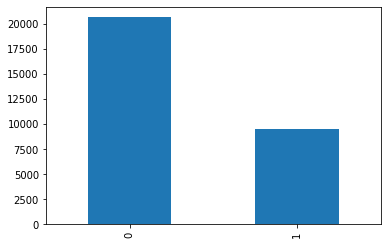

In [ ]:
labels_class.Target.value_counts().plot(kind = 'bar')
plt.show()

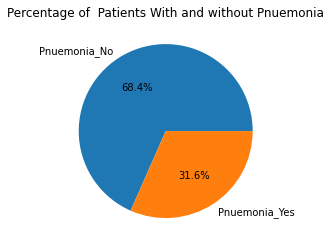

In [ ]:
#Pie Chart
labels = ['Pnuemonia_No', 'Pnuemonia_Yes']
plt.pie(labels_class['Target'].value_counts(), labels = labels, autopct='%1.1f%%')
plt.title("Percentage of  Patients With and without Pnuemonia")
plt.show()

In [ ]:
print(labels_class['class'].value_counts())

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


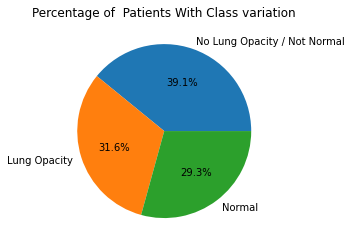

In [ ]:
#Pie Chart
labels = ['No Lung Opacity / Not Normal', 'Lung Opacity','Normal']
plt.pie(labels_class['class'].value_counts(), labels = labels, autopct='%1.1f%%')
plt.title("Percentage of  Patients With Class variation")
plt.show()

In [ ]:
pd.crosstab(labels_class['class'], labels_class['Target'],margins=True)

Target,0,1,All
class,,,
Lung Opacity,0,9555,9555
No Lung Opacity / Not Normal,11821,0,11821
Normal,8851,0,8851
All,20672,9555,30227


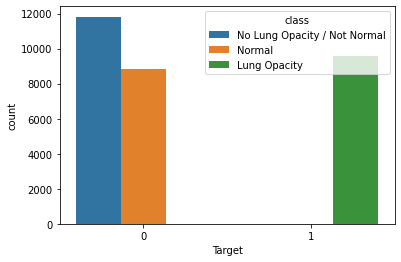

In [ ]:
sns.countplot(x='Target',data=labels_class,hue ='class');

## Observations
* Out of 68.4% Having no Pnuemonia 39.1% has class of No lung Opacity/Not Normal and 29.3% with clas as Normal

## Checking the Patients who has more locations of  Pnuemonia  or bounding boxes
* No. of Nulls for the boundary boxes matches with number of target class of No Pnuemonia.( 20672)
* Out of 9555 Pnueomia there might be duplicate patients who has more than one bounding box

In [ ]:
print(labels_class.groupby('patientId')['Target'].size().sort_values(ascending = False))

patientId
76f71a93-8105-4c79-a010-0cfa86f0061a    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
                                       ..
6b1319bc-6253-47b8-9f36-c694bef288d0    1
6b110a37-e31c-437d-8886-c2e7cd5b2cb2    1
6b10737e-ec37-4f37-8db3-a95434db6016    1
6b0fa27d-7ca7-4b56-92c7-a389988ec660    1
fffec09e-8a4a-48b1-b33e-ab4890ccd136    1
Name: Target, Length: 26684, dtype: int64


In [ ]:
labels_class_target1 = labels_class.loc[(labels_class['Target'] ==1)]
labels_class_target1.shape

(9555, 7)

In [ ]:
print(labels_class_target1.groupby('patientId')['Target'].size().sort_values(ascending = False))

patientId
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
7d674c82-5501-4730-92c5-d241fd6911e7    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
                                       ..
3b4decc7-fed9-46fd-9d30-179b7cde4a2c    1
3b4a83a5-e755-4b20-b21c-0a0424095325    1
a2d27e14-d9c0-4596-84d8-c526b0afc9a7    1
a2ddccd7-9c2b-4d81-9375-928b418da482    1
35726244-0298-433e-9376-d1a1fe5724cf    1
Name: Target, Length: 6012, dtype: int64


In [ ]:
print(labels_class_target1.groupby('patientId')['Target'].size().sort_values(ascending = False).value_counts())

2    3266
1    2614
3     119
4      13
Name: Target, dtype: int64


## Observations
* We do have 6012 patients who has Pnuemonia and rest 20672 patients without Pnuemonia
* Out of 6012 patients 12 have 4 bounding boxes,119 with 3,2614 with 1 and 3266 with 2 boxes
* There is high class imbalance

## Checking the Majority of Rectangular box locations on the lungs
* Center of the Box is plotted to understand the position of box over two lungs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


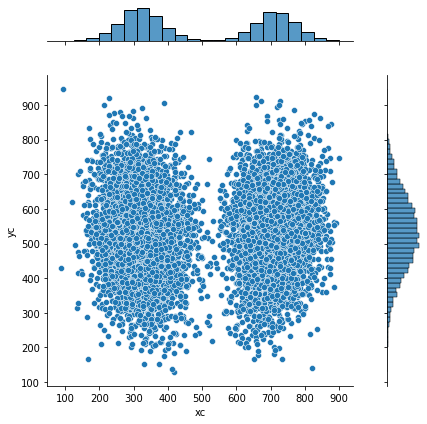

In [ ]:
labels_class_target1['xc'] = labels_class_target1['x'] + labels_class_target1['width']/2
labels_class_target1['yc'] = labels_class_target1['y'] + labels_class_target1['height']/2

sns.jointplot(x = labels_class_target1['xc'], y = labels_class_target1['yc'], data = labels_class_target1,
                  kind = 'scatter',space=1)

In [ ]:
print(labels_class_target1['yc'].mean())

531.4744113029827


### Observations
* We can see two lungs having Pnuemonia detected rectangular boxes with majority at center of lungs
* Could see few outlier boxes which may or may not have proper boxes which has Pnuemonia and might be the boxes are not on the lungs itself

# Reading the Images

In [ ]:
dcm_images = dcm.dcmread('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')

In [ ]:
print(dcm_images)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

## Observations
* Based on the DCM file we see that the important parameters that can be extracted are
* Patient Age
* Patient Sex
* Picture size ( RowsXColumns) - Helpful for CNN
* View position -AP or PV - This is important  whether the receptor board is close to the Chest or back of the Chest
* Pixel spacing- Distance the object Vs Image receptor where the picture is captured

In [ ]:
images_df=labels_class.copy()

In [ ]:
from pathlib import Path
data = Path('stage_2_train_images')
train_images=list(data.glob('*.dcm'))

In [ ]:
len(train_images)

26684

In [ ]:
images = []
for img in glob.glob("stage_2_train_images/*.dcm"):
    image_dcm = dcm.read_file(img)
    images.append(image_dcm)
        


## Train and Test images

In [ ]:
for img in glob.glob("stage_2_train_images/*.dcm"):
    image_dcm = dcm.read_file(img)
    idx = (images_df['patientId'] == image_dcm.PatientID)
    images_df.loc[idx, 'PatientAge'] = pd.to_numeric(image_dcm.PatientAge)
    images_df.loc[idx, 'PatientSex'] = image_dcm.PatientSex
    images_df.loc[idx, 'ViewPosition'] = image_dcm.ViewPosition
    images_df.loc[idx, 'Rows'] = image_dcm.Rows
    images_df.loc[idx, 'Columns'] = image_dcm.Columns
    images_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", image_dcm.PixelSpacing[0])

In [ ]:
images_df.to_pickle("images_train_df.pkl")

In [ ]:
images_df.to_csv('images_train_excel.csv',index=False)

In [ ]:
import pickle

In [ ]:
with open('trainimagesdata.pkl', 'wb') as f:
    pickle.dump(images, f)

# EDA with Image data for Train and Test

In [ ]:
images_df = pd.read_pickle('images_train_df.pkl')

In [ ]:
images_df.head(3)

,patientId,x,y,width,height,Target,class,PatientAge,PatientSex,ViewPosition,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51.0,F,PA,1024.0,1024.0,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48.0,F,PA,1024.0,1024.0,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19.0,M,AP,1024.0,1024.0,0.168


### Test images data frame

In [ ]:
test_df=images_df.copy()

In [ ]:
test_df.drop(test_df.index, inplace=True)

In [ ]:
test_df.drop(['x','y','width','height','Target','class'],inplace=True, axis=1)

In [ ]:
dcm_test = dcm.dcmread('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')

In [ ]:
print(dcm_test)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
idx =0
for img in glob.glob("stage_2_test_images/*.dcm"):
    image_dcm = dcm.read_file(img)
    test_df.loc[idx, 'patientId'] = image_dcm.PatientID
    test_df.loc[idx, 'PatientAge'] = pd.to_numeric(image_dcm.PatientAge)
    test_df.loc[idx, 'PatientSex'] = image_dcm.PatientSex
    test_df.loc[idx, 'ViewPosition'] = image_dcm.ViewPosition
    test_df.loc[idx, 'Rows'] = image_dcm.Rows
    test_df.loc[idx, 'Columns'] = image_dcm.Columns
    test_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", image_dcm.PixelSpacing[0])
    idx=idx+1

In [ ]:
test_df.head()

,patientId,PatientAge,PatientSex,ViewPosition,Rows,Columns,PixelSpacing
0,2602635c-7751-44db-82b3-ea47dd399121,50.0,F,PA,1024.0,1024.0,0.168
1,258f5240-8010-4472-91fe-494f75d59a46,22.0,M,AP,1024.0,1024.0,0.171
2,255952dd-d7d1-4329-a713-43039c15e2f3,59.0,M,AP,1024.0,1024.0,0.139
3,263db843-751f-4cd1-b392-548fe40d2636,54.0,M,AP,1024.0,1024.0,0.139
4,24f7c131-9d07-4251-83fc-20ab9079e326,50.0,M,PA,1024.0,1024.0,0.194


### Train and test images in dataframe

In [ ]:
test_images = []
for img in glob.glob("stage_2_test_images/*.dcm"):
    image_dcm = dcm.read_file(img)
    test_images.append(image_dcm)

In [ ]:
with open('trainimagesdata.pkl', 'rb') as f:
    train_images = pickle.load(f)

In [ ]:
images_df.head()

,patientId,x,y,width,height,Target,class,PatientAge,PatientSex,ViewPosition,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51.0,F,PA,1024.0,1024.0,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48.0,F,PA,1024.0,1024.0,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19.0,M,AP,1024.0,1024.0,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28.0,M,PA,1024.0,1024.0,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32.0,F,AP,1024.0,1024.0,0.139


In [ ]:
print(images_df['Rows'].min())
print(images_df['Rows'].max())
print(images_df['Rows'].mean())

1024.0
1024.0
1024.0


In [ ]:
print(images_df['Columns'].min())
print(images_df['Columns'].max())
print(images_df['Columns'].mean())

1024.0
1024.0
1024.0


## Observations
* Looks like the images are of same size and hence we can delete this attribute

In [ ]:
train_df = images_df.copy()

In [ ]:
train_df['x'] = train_df['x'].fillna(0)
train_df['y'] = train_df['y'].fillna(0)
train_df['width'] = train_df['width'].fillna(0)
train_df['height'] = train_df['height'].fillna(0)

In [ ]:
train_df['xc'] = train_df['x'] + train_df['width']/2
train_df['yc'] = train_df['y'] + train_df['height']/2

In [ ]:
train_df['Area'] = train_df['x']*train_df['width']

In [ ]:
train_df=train_df.drop(['Rows','Columns'],axis=1)

In [ ]:
train_df.shape

(30227, 14)

In [ ]:
train_dp = train_df.drop_duplicates(subset=['patientId'])

In [ ]:
train_dp.shape

(26684, 14)

### Percentage of Patients with and Without Pnuemonia

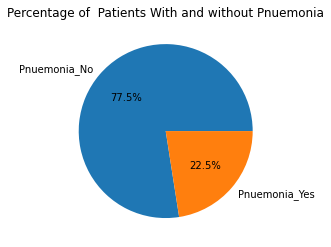

In [ ]:
#Pie Chart
labels = ['Pnuemonia_No', 'Pnuemonia_Yes']
plt.pie(train_dp['Target'].value_counts(), labels = labels, autopct='%1.1f%%')
plt.title("Percentage of  Patients With and without Pnuemonia")
plt.show()

In [ ]:
len(train_dp.loc[train_dp['Target'] == 1])

6012

### Patients with Pnuemonia and Male Female Ratio

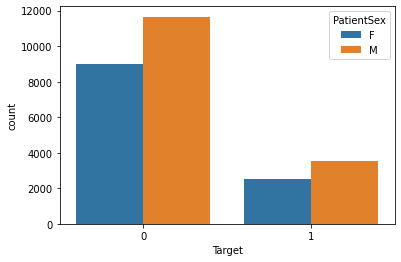

In [ ]:
sns.countplot(x='Target',data=train_dp,hue ='PatientSex');

In [ ]:
pd.crosstab(train_dp['Target'], train_dp['PatientSex'],margins=True)

PatientSex,F,M,All
Target,,,
0,9016,11656,20672
1,2502,3510,6012
All,11518,15166,26684


* Male Patients affected with Pnuemonia is high compared to Female
* X ray taken for Male Patients are also high

### Patients with Pnuemonia and Position of XRay taken
### Overall Patients with Position of XRay taken

In [ ]:
pd.crosstab(train_dp['Target'], train_dp['ViewPosition'],margins=True)

ViewPosition,AP,PA,All
Target,,,
0,7509,13163,20672
1,4664,1348,6012
All,12173,14511,26684


In [ ]:
pd.crosstab(train_dp['Target'], train_dp['ViewPosition'],margins=True,normalize='index')

ViewPosition,AP,PA
Target,,
0,0.363245,0.636755
1,0.775782,0.224218
All,0.456191,0.543809


* Patients taken with AP Posture ( Normally sick already) has higher chances of Pnuemonia - Close to 77% out of total Pnuemonia patients
* Clustering the images into AP and PA has good chances of predictions of Pnuemonia
* Percentage of people with PA Posture are higher


### Patients with Pnuemonia and Age group

<Figure size 1080x1080 with 0 Axes>

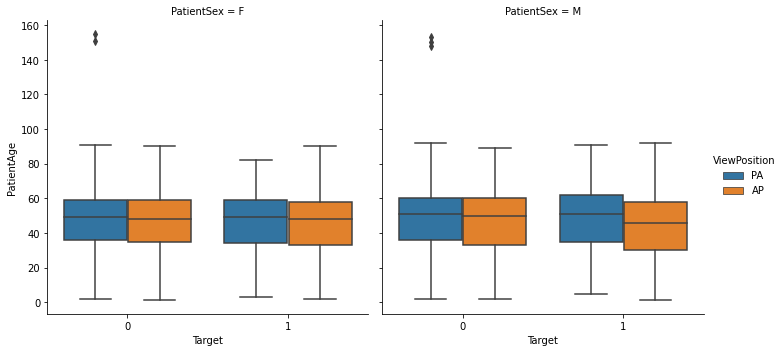

In [ ]:
plt.figure(figsize=(15,15))
sns.catplot(x="Target",
               y = "PatientAge",
               hue="ViewPosition", 
               col="PatientSex",
               data=train_dp, 
               kind="box");

In [ ]:
train_dp["PixelSpacing"] = train_dp.PixelSpacing.astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 1080x1080 with 0 Axes>

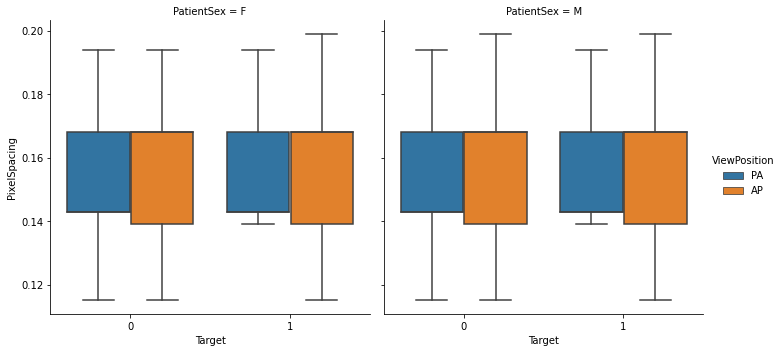

In [ ]:
plt.figure(figsize=(15,15))
sns.catplot(x="Target",
               y = "PixelSpacing",
               hue="ViewPosition", 
               col="PatientSex",
               data=train_dp, 
               kind="box");

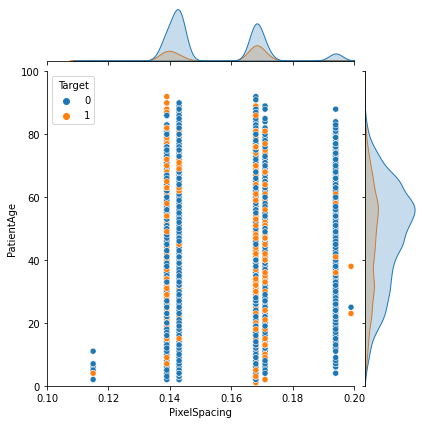

In [ ]:
sns.jointplot(x=train_dp['PixelSpacing'], y=train_dp['PatientAge'], hue=train_dp['Target'],
              kind="scatter",ylim=(0.0, 100),xlim=(0.1, 0.2));

* Patients with Pnuemonia It shows that the median average age for AP position for Male is lower compared to Female
* There are few patients whose age is much higher. Outleirs due to typo error and for the patients who doesnot have Pnuemonia
* Patients who are affected with Pnuemonia the Pixel spacing for PA has minimum starting from 0.14 where as AP position it has 0.11
* Pixel spacing for Patient age group is less than 10y for the pixel spacing around 0.12.
* Pixelspacing between 0.16 to 0.18 has larger number of patients affected with Pnuemonia 
* When the pixel spacing is large the number of cases of Pnueomia detection is lower

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

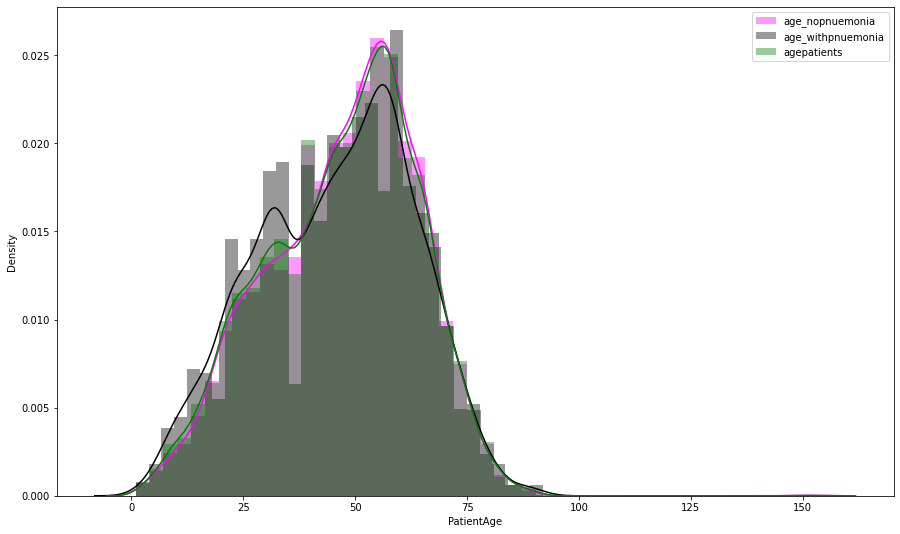

In [ ]:
age_target0 = train_dp.loc[train_dp.Target == 0, 'PatientAge']
age_target1 = train_dp.loc[train_dp.Target == 1, 'PatientAge']
age_all = train_dp['PatientAge']

f, ax = plt.subplots(figsize=(15, 9))
sns.distplot(age_target0, bins=15,color = 'magenta', label = 'age_nopnuemonia')
sns.distplot(age_target1,bins=15, color = 'black', label = 'age_withpnuemonia')
sns.distplot(age_all, bins=15,color = 'green', label = 'agepatients')
plt.legend()
plt.show()

* We can see the mostly effected patients coming for Pnuemonia check are in the age group of 50 to 60 and most number of infected patients are also in the same age group
* We can see from 30 to 40y age group are effected more with Pnuemonia

## Relation between Age and Box area

In [ ]:
train_df_target =  train_df.loc[(train_df['Target'] ==1)]

In [ ]:
train_df_age15 =  train_df_target.loc[(train_df_target['PatientAge']<=15)]

In [ ]:
train_df_age15_30 =  train_df_target.loc[(train_df_target['PatientAge'] > 15) & (train_df_target['PatientAge']<=30)]

In [ ]:
train_df_age30_50 =  train_df_target.loc[(train_df_target['PatientAge'] > 30) & (train_df_target['PatientAge']<=50)]

In [ ]:
train_df_age50_60 =  train_df_target.loc[(train_df_target['PatientAge'] > 50) & (train_df_target['PatientAge']<=60)]

In [ ]:
train_df_age60_80 =  train_df_target.loc[(train_df_target['PatientAge'] > 60) & (train_df_target['PatientAge']<=80)]

In [ ]:
train_df_age_gr80 =  train_df_target.loc[(train_df_target['PatientAge'] >= 80)]

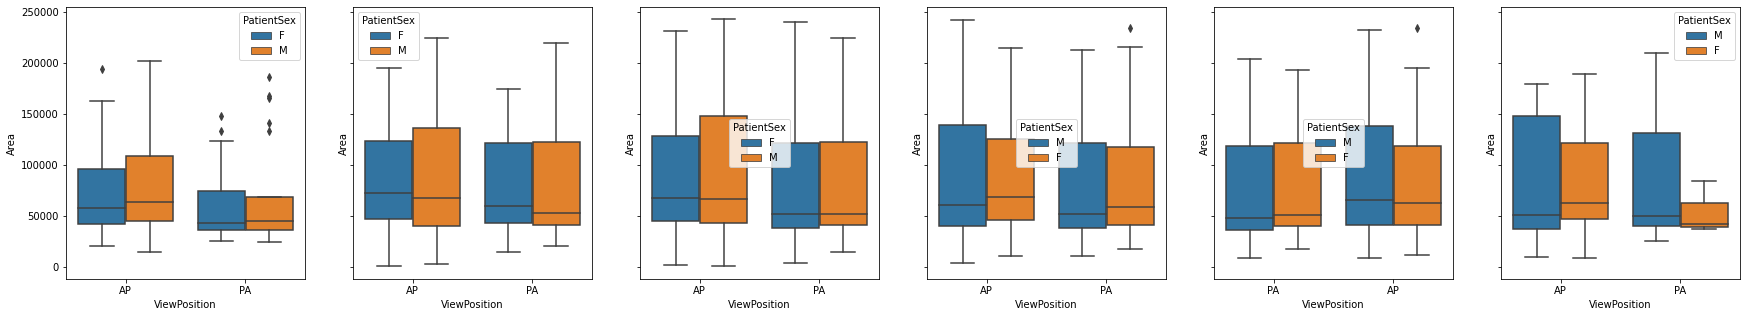

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(30, 5),sharey=True)
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age15,ax=axes[0]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age15_30,ax=axes[1]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age30_50,ax=axes[2]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age50_60,ax=axes[3]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age60_80,ax=axes[4]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age_gr80,ax=axes[5]);

### Relation between Box centers Vs Age Vs Pixel spacing

In [ ]:
train_df_target1 =  train_df.loc[(train_df['Target'] ==1)]

In [ ]:
train_df_age50_60 =  train_df_target1.loc[(train_df_target1['PatientAge'] > 50) & (train_df_target1['PatientAge']<60)]

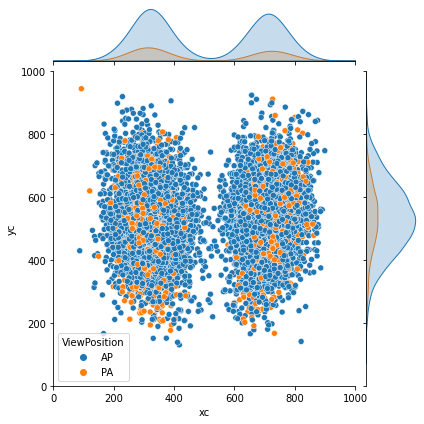

In [ ]:
#fig, axes = plt.subplots(1, 2, figsize=(15, 10))
sns.jointplot(x=train_df_target1['xc'], y=train_df_target1['yc'], hue=train_df_target1['ViewPosition'],
              kind="scatter",ylim=(0, 1000),xlim=(0, 1000));

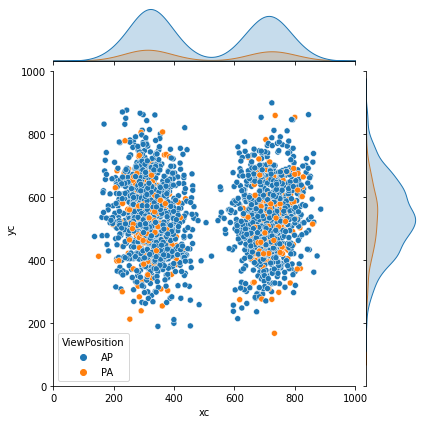

In [ ]:
sns.jointplot(x=train_df_age50_60['xc'], y=train_df_age50_60['yc'],
              kind="scatter", hue=train_df_age50_60['ViewPosition'],ylim=(0, 1000),xlim=(0, 1000));

* Patients with Box centers for PA position are mostly concentrated at the centers
* AP Position has centers all over the lungs area the detection of Pneumonia
* Few Outlier boxes are visible for the left lungs with PA position

## Comparision of Train and Test data

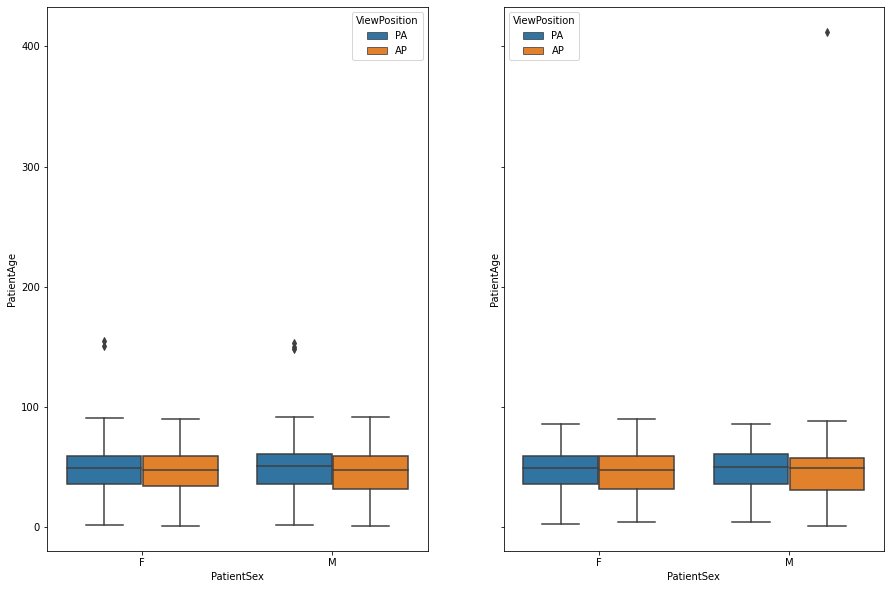

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10),sharey=True)
sns.boxplot(x="PatientSex",
               y = "PatientAge",
               hue="ViewPosition", 
               data=train_dp,ax=axes[0]);
sns.boxplot(x="PatientSex",
               y = "PatientAge",
               hue="ViewPosition", 
               data=test_df,ax=axes[1]);
               

* Train and Test data looks similar interms of number of Male and Female Patients and Age deviations
* Outliers with age > 400 is a typo error in Test data and also >120y age in Train data

In [ ]:
def remove_outliers(X_train_hr,col):
        q1 = X_train_hr[col].quantile(0.25)
        q3 = X_train_hr[col].quantile(0.75)
        IQR = q3 - q1
    
        low_whisk = q1 - 2.5 * IQR
        up_whisk = q3 + 2.5 * IQR
    
        X_train_hr.loc[(X_train_hr[col] < low_whisk) | (X_train_hr[col] > up_whisk), col] = X_train_hr[col].median()
        return X_train_hr

In [ ]:
train_dp_outlier=remove_outliers(train_dp,'PatientAge')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
test_df_outlier=remove_outliers(test_df,'PatientAge')

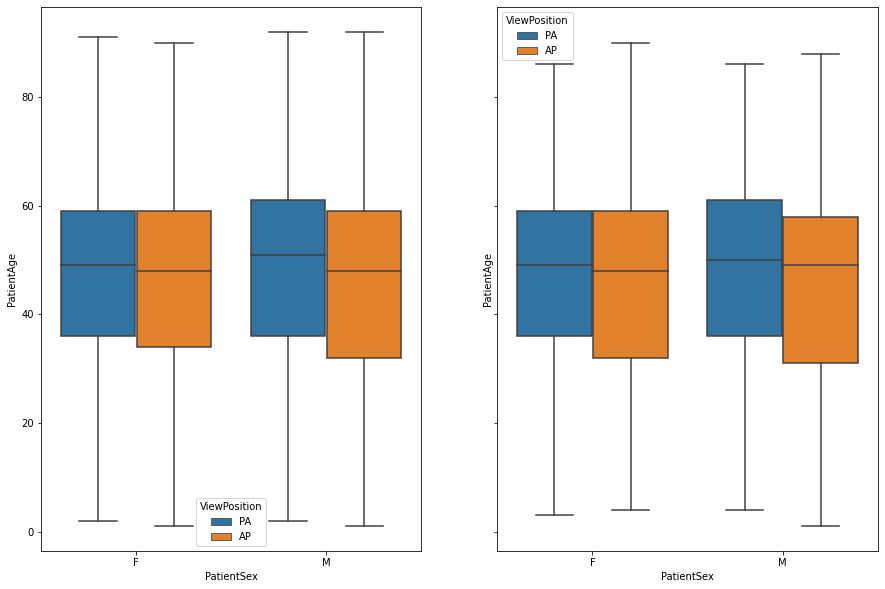

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10),sharey=True)
sns.boxplot(x="PatientSex",
               y = "PatientAge",
               hue="ViewPosition", 
               data=train_dp_outlier,ax=axes[0]);
sns.boxplot(x="PatientSex",
               y = "PatientAge",
               hue="ViewPosition", 
               data=test_df_outlier,ax=axes[1]);

### Clearly shows there is good similarity between Train and Test data.

## Checking the Images with Boxes

In [ ]:
train_df.head()

,patientId,x,y,width,height,Target,class,PatientAge,PatientSex,ViewPosition,PixelSpacing,xc,yc
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,51.0,F,PA,0.143,0.0,0.0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,48.0,F,PA,0.194,0.0,0.0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,19.0,M,AP,0.168,0.0,0.0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,28.0,M,PA,0.143,0.0,0.0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32.0,F,AP,0.139,370.5,341.5


## Patient ID with No Pnuemonia

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
img_path='stage_2_train_images'

In [ ]:
def patient_dicom(patient):
    #fig, ax = plt.subplots(1, 1)
    plt.grid(False)
    ax = plt.gca()
    image = patient + '.dcm'
    path = os.path.join(img_path, image)
    image_dcm = dcm.read_file(path)
    ax.imshow(image_dcm.pixel_array,cmap='bone')
    ax = plt.gca()
    boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
    for box in boxes:
        x=box[0]
        y=box[1]
        w=box[2]
        h=box[3]
        ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))
        #rect=Rectangle((x, y), w, h, linewidth=2, edgecolor='r', fill=False)
        #ax.add_patch(rect)
        #plt.show()

In [ ]:
patient='0004cfab-14fd-4e49-80ba-63a80b6bddd6'

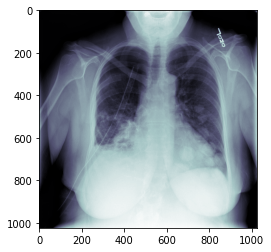

In [ ]:
patient_dicom(patient)

## Patient ID with Pnuemonia

In [ ]:
patient='00436515-870c-4b36-a041-de91049b9ab4'

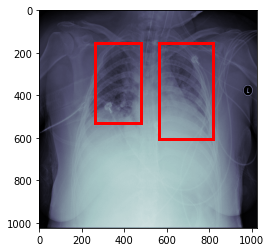

In [ ]:
patient_dicom(patient)

In [ ]:
patient='0ab261f9-4eb5-42ab-a9a5-e918904d6356'

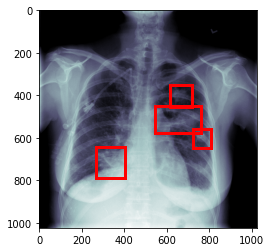

In [ ]:
patient_dicom(patient)

# Checking the images for Age group less than 15

In [ ]:
train_df_age15.head()

,patientId,x,y,width,height,Target,class,PatientAge,PatientSex,ViewPosition,PixelSpacing,xc,yc,Area
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity,6.0,F,AP,0.168,335.0,389.5,27072.0
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1,Lung Opacity,6.0,F,AP,0.168,606.5,381.5,65093.0
51,01be392f-a46d-4aef-a57e-9cd1a80dd47e,535.0,626.0,177.0,240.0,1,Lung Opacity,14.0,M,AP,0.171,623.5,746.0,94695.0
52,01be392f-a46d-4aef-a57e-9cd1a80dd47e,175.0,825.0,168.0,109.0,1,Lung Opacity,14.0,M,AP,0.171,259.0,879.5,29400.0
80,01fa0f5e-00c3-41cb-b5c7-10600c8633ae,602.0,438.0,101.0,101.0,1,Lung Opacity,2.0,M,AP,0.168,652.5,488.5,60802.0


In [ ]:
def random_dcoms(number,df):
    plt.figure(figsize=(10,10))
    for i in range(number):
        plt.subplot(3, 3, i+1)
        patient= np.random.choice(df['patientId'].values)
        patient_dicom(patient)

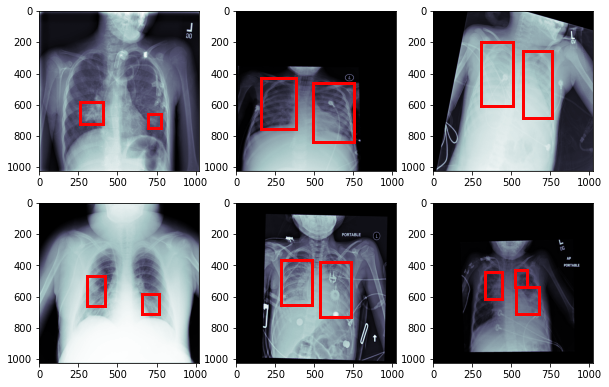

In [ ]:
random_dcoms(6,train_df_age15)

In [ ]:
train_df_target.PatientAge.value_counts()

58.0    374
56.0    294
40.0    286
52.0    259
46.0    232
       ... 
4.0       2
89.0      2
1.0       2
92.0      1
83.0      1
Name: PatientAge, Length: 92, dtype: int64

##  Patients with less than 4y

In [ ]:
train_df_age4 =  train_df_target.loc[(train_df_target['PatientAge']<=4)]

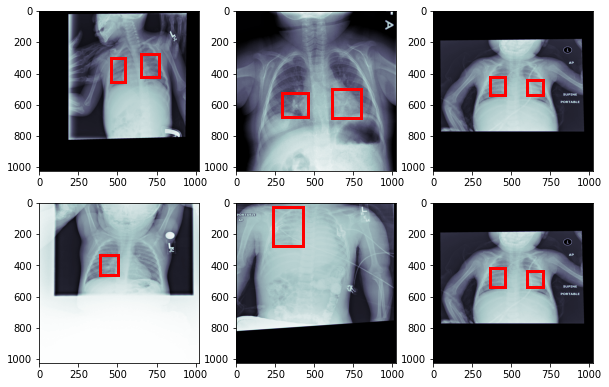

In [ ]:
random_dcoms(6,train_df_age4)

# Patients age between 50 to 60

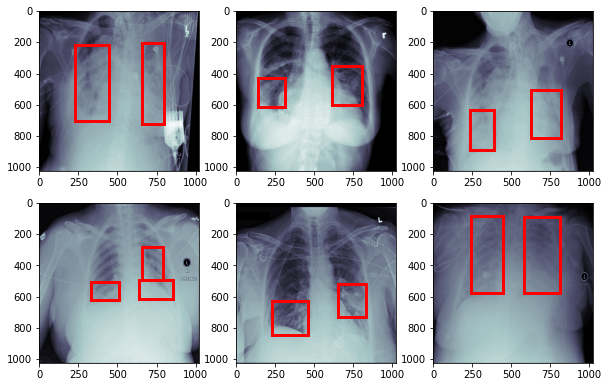

In [ ]:
random_dcoms(6,train_df_age50_60)

# Patients above 80y

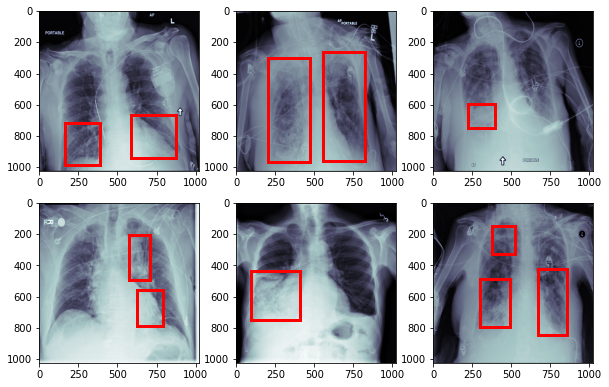

In [ ]:
random_dcoms(6,train_df_age_gr80)

# Image Normalization using Histrogram/CLACHE

### Pixel distribution

In [ ]:
def random_histograms(number,df):
    plt.figure(figsize=(10,5))
    for i in range(number):
        patient= np.random.choice(df['patientId'].values)
        #pixeldistribution(patient)
        image = patient + '.dcm'
        path = os.path.join(img_path, image)
        image_dcm = dcm.read_file(path)
      #sns.distplot(image_dcm.ravel())
        image_dcm = image_dcm.pixel_array
        n_bins = 30
        plt.subplot(1, 2, i+1)
        plt.hist(image_dcm.flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
        plt.subplot(1, 2, i+2)
        plt.imshow(image_dcm,cmap='bone')
        plt.grid(False)
        ax = plt.gca()
        boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
        for box in boxes:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

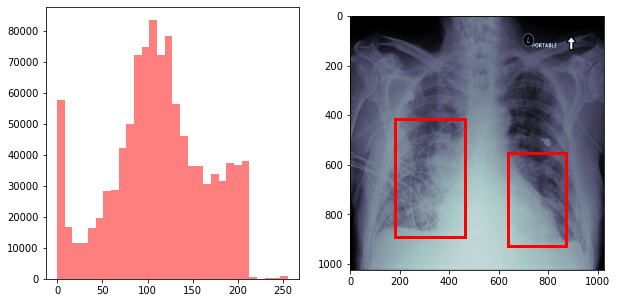

In [ ]:
random_histograms(1,train_df_age_gr80)

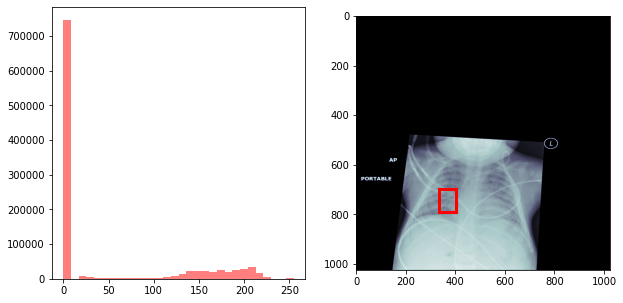

In [ ]:
random_histograms(1,train_df_age4)

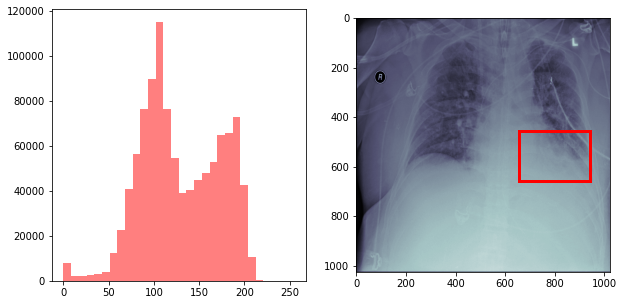

In [ ]:
random_histograms(1,train_df_age50_60)

In [ ]:
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure

In [ ]:
patient='0ab261f9-4eb5-42ab-a9a5-e918904d6356'

## without Normalization

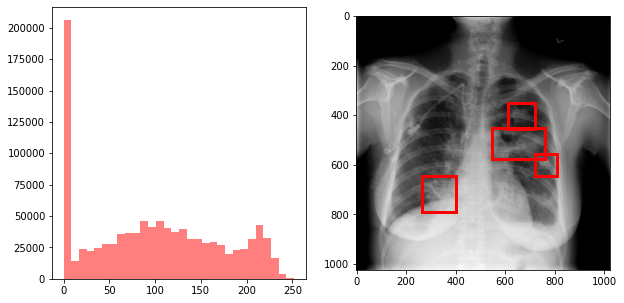

In [ ]:
image = patient + '.dcm'
path = os.path.join(img_path, image)
image_dcm = dcm.read_file(path)
image_dcm = image_dcm.pixel_array
img = image_dcm
n_bins = 30
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.grid(False)
ax = plt.gca()
boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
for box in boxes:
    x=box[0]
    y=box[1]
    w=box[2]
    h=box[3]
    ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

## Histogram Normalized

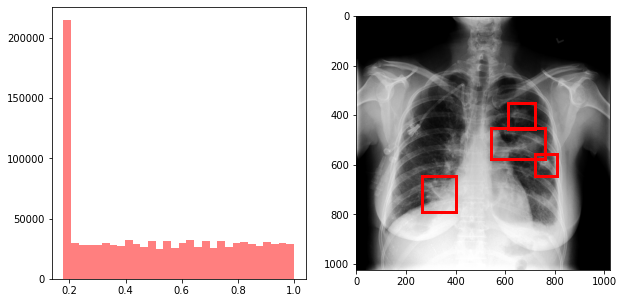

In [ ]:
image = patient + '.dcm'
path = os.path.join(img_path, image)
image_dcm = dcm.read_file(path)
image_dcm = image_dcm.pixel_array
img = exposure.equalize_hist(image_dcm)
n_bins = 30
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.grid(False)
ax = plt.gca()
boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
for box in boxes:
    x=box[0]
    y=box[1]
    w=box[2]
    h=box[3]
    ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

## CLACHE Normalized
* Produces sharper images ( Bone Enhanced View) 

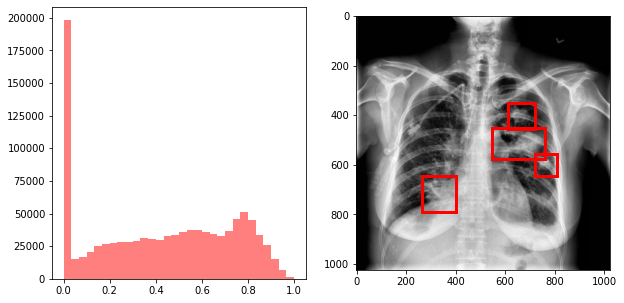

In [ ]:
image = patient + '.dcm'
path = os.path.join(img_path, image)
image_dcm = dcm.read_file(path)
image_dcm = image_dcm.pixel_array
img = exposure.equalize_adapthist(image_dcm/np.max(image_dcm))
n_bins = 30
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.grid(False)
ax = plt.gca()
boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
for box in boxes:
    x=box[0]
    y=box[1]
    w=box[2]
    h=box[3]
    ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

### Conclusion is the detection of white spots is much more clear with CLACHE Normalization

# Model - Predicting Mask using AutoEncoder-UNet

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb 27 06:13:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os; os.chdir('/content/drive/MyDrive/Capstone')

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
!pip install pydicom
import pydicom as dicom
import cv2
import os
from google.colab.patches import cv2_imshow
import csv
import keras

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [6]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.metrics import MeanIoU
from tensorflow.keras import layers
from keras.callbacks import CSVLogger
import datetime
import pydicom as dicom

In [7]:
keras = tf.compat.v1.keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import seaborn as sns

### Convert images to Jpeg

In [ ]:
import cv2
import os
folder_path = 'stage_2_train_images'
jpg_path = "image_jpeg"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_path, image), pixel_array_numpy)

### Creating Masks

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import csv
import os

mask_path = "/content/drive/MyDrive/Capstone/masks/"
csv_path = "/content/drive/MyDrive/Capstone/stage_2_train_labels.csv"

sheet = open(csv_path, newline='')

images_path = os.listdir("/content/drive/MyDrive/Capstone/image_jpeg")
images_path = [os.path.splitext(x)[0] for x in images_path]
images_path = [x.strip() for x in images_path]
i=1
for image_name in images_path: 
    sheet = open(csv_path, newline='')
    reader = csv.reader(sheet)
    for row in reader:
      if row[0]==image_name:
        print(image_name)
        print(i)
        i+=1
        if row[5]=='1':
          pt1 = (int(row[1].split('.')[0]),int(row[2].split('.')[0]))
          pt2 = int(row[1].split('.')[0])+int(row[3].split('.')[0]),int(row[2].split('.')[0])+int(row[4].split('.')[0])

          if os.path.isfile(mask_path+image_name+'.jpg')==True:       
            img = cv2.imread(mask_path+image_name+'.jpg')
          else:
            img = np.zeros((1024, 1024, 3), dtype = "uint8")
          cv2.rectangle(img, pt1, pt2, (255,255,255), -1)
          cv2.imwrite(mask_path+image_name+'.jpg', img)  
          #cv2_imshow(img)
        else:  
          img = np.zeros((1024, 1024, 3), dtype = "uint8")
          cv2.imwrite(mask_path+row[0]+'.jpg', img)
    sheet.close()

In [ ]:
folder = 'masks'
filenames = os.listdir(folder)
print('Number of Train images:', len(filenames))

Number of Train images: 26684


In [ ]:
folder = 'image_jpeg'
filenames = os.listdir(folder)
print('Number of Train images:', len(filenames))

Number of Train images: 26684


## DataFrame with image data attributes

In [8]:
images_df = pd.read_pickle('images_train_df.pkl')

In [9]:
train_df = images_df.copy()

In [10]:
train_df['x'] = train_df['x'].fillna(0)
train_df['y'] = train_df['y'].fillna(0)
train_df['width'] = train_df['width'].fillna(0)
train_df['height'] = train_df['height'].fillna(0)

In [11]:
train_df['xc'] = train_df['x'] + train_df['width']/2
train_df['yc'] = train_df['y'] + train_df['height']/2

In [12]:
train_df['Area'] = train_df['height']*train_df['width']

In [13]:
train_df=train_df.drop(['Rows','Columns'],axis=1)

In [14]:
train_df.shape

(30227, 14)

In [15]:
train_dp = train_df.drop_duplicates(subset=['patientId'])

In [ ]:
train_dp_1 =  train_dp.loc[(train_dp['Target'] ==1)]

In [ ]:
train_dp_0 =  train_dp.loc[(train_dp['Target'] ==0)]

In [ ]:
idx = np.random.rand(len(train_dp_0)) < 0.3
train_dp_0 = train_dp_0[idx]

In [ ]:
train_dp_0.shape

(6196, 14)

In [ ]:
train_dp_1.shape

(6012, 14)

In [ ]:
train_dp_downsample=pd.concat([train_dp_0,train_dp_1],axis=0)

In [ ]:
from sklearn.utils import shuffle
train_dp_downsample = shuffle(train_dp_downsample)

In [ ]:
train_dp_downsample.shape

(12208, 14)

## Train validation split

In [ ]:
idx = np.random.rand(len(train_dp_downsample)) < 0.8
val_df = train_dp_downsample[~idx]
train_df = train_dp_downsample[idx]
val_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

In [ ]:
train_df.shape, val_df.shape

((9663, 15), (2422, 15))

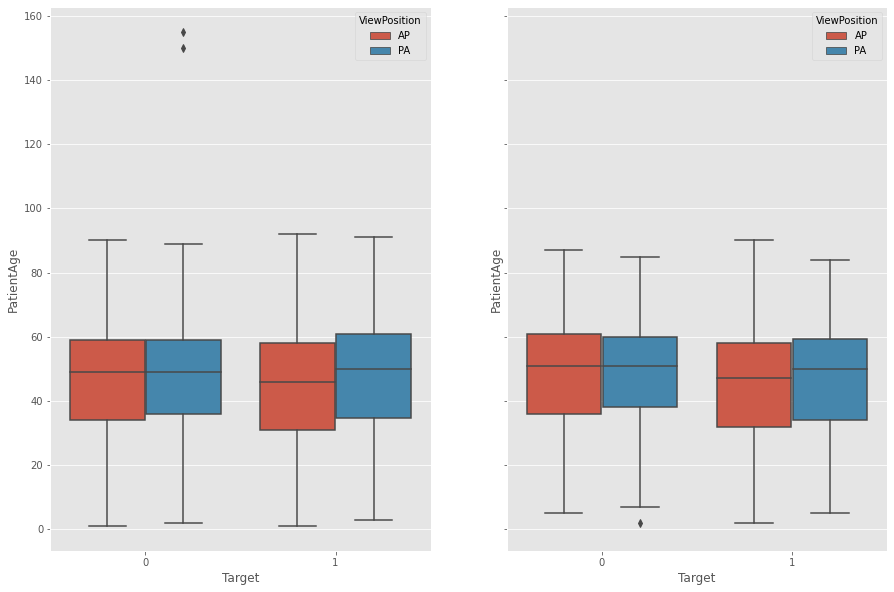

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10),sharey=True)
sns.boxplot(x="Target",
               y = "PatientAge",
               hue="ViewPosition", 
               data=train_df,ax=axes[0]);
sns.boxplot(x="Target",
               y = "PatientAge",
               hue="ViewPosition", 
               data=val_df,ax=axes[1]);

### Checking Image and Masks

In [ ]:
base_size=1024

In [16]:
def display_image_mask(img_num, df):

    #Create a pyplot with two images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))

    #Read  image and corresponding mask
    img = tf.keras.preprocessing.image.load_img('image_jpeg/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')

    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')
    
    patient=df.loc[img_num, 'patientId']
    #Show both images
    ax1.set_title('Image')
    ax1.imshow(img, cmap = 'gray', interpolation = 'bilinear')
    ax1.axis('on')
  
    ax2.set_title('Mask')
    ax2.imshow(mask_img, cmap = 'gray', interpolation = 'bilinear')
    ax2.axis('on')
    plt.show()

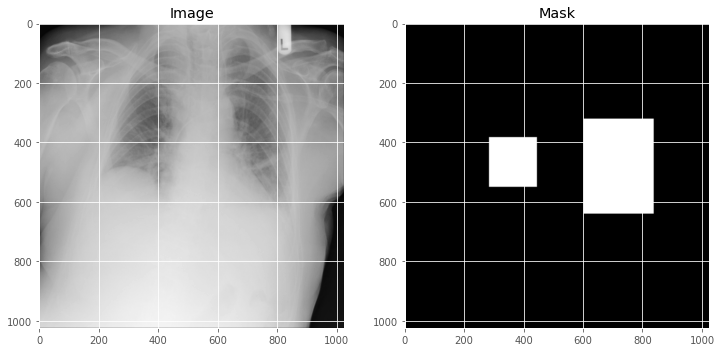

In [ ]:
img_num = np.random.randint(0, train_df.shape[0])
display_image_mask(img_num, train_df)

### Batch generator - No Normalization of Image

In [ ]:
img_size = 128
num_classes = 2

In [ ]:
def batch_generator(df, batch_size=32):

    while True:

        #Create random indexes
        idx = np.random.randint(0, df.shape[0], batch_size)

        #Initialize numpy arrays for X and y
        #Input image is size img_size,img_size,1
        #X = np.zeros((batch_size, img_size, img_size,3))
        X = np.zeros((batch_size, img_size, img_size, 1), dtype=np.float32)
        #Mask's size is img_size, img_size, 1
        y = np.zeros((batch_size, img_size, img_size,num_classes))
        #y = np.zeros((batch_size, img_size, img_size,1))

        #Populate X and y with actual data
        for i in range(len(idx)):

            #Read image
            img = tf.keras.preprocessing.image.load_img('image_jpeg/' + df.loc[idx[i],'patientId'] + '.jpg', color_mode='grayscale',
                                                        target_size=(img_size, img_size))
            img = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')/255.0

            X[i] = img

            #Read mask
            mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[idx[i],'patientId'] + '.jpg',
                                                            color_mode = 'grayscale',
                                                            target_size=(img_size, img_size))
            mask_img = tf.keras.preprocessing.image.img_to_array(mask_img).astype('uint8')/255.0
            mask_img = tf.keras.utils.to_categorical(mask_img, num_classes=num_classes)

            y[i] = mask_img

        yield X, y

In [ ]:
a = batch_generator(train_df, batch_size=2)
x, y = next(a)

In [ ]:
x.shape

(2, 128, 128, 1)

In [ ]:
 y.shape

(2, 128, 128, 2)

In [ ]:
np.unique(y[0])

array([0., 1.])

# Building Standalone UNET-Without BackBone

In [ ]:
def conv2d_block(input_tensor, n_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [ ]:
def build_unet(input_img, n_filters=16, dropout=0.1):

    #ENCODER - DOWNSAMPLE the image - 128x128x1

    #First Block
    c1 = conv2d_block(input_img, n_filters*1) #128x128x16
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) #64x64x16
    p1 = tf.keras.layers.Dropout(dropout)(p1) #64x64x16
    #output will be 64x64x16 for image size 128x128x1

    #Second Block
    c2 = conv2d_block(p1, n_filters*2) #64x64x32
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) #32x32x32
    p2 = tf.keras.layers.Dropout(dropout)(p2)
    #output will be 32x32x32

    #Third Block
    c3 = conv2d_block(p2, n_filters*4) #32x32x64
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3) #16x16x64
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    #output will be 16x16x64

    #Fourth Block
    c4 = conv2d_block(p3, n_filters*8) #16x16x128
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)
    ##output will be 8x8x128 

    #Fifth Block
    c5 = conv2d_block(p4, n_filters*16)
    #output will be 8x8x256

    #We now have output of Encoder

    #DECODER - UPSAMPLE the feature to generate mask

    #First Block - connected to fourth block on DOWNSAMPLE side
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), 
                                         strides = (2, 2), 
                                         padding = 'same')(c5) #16x16x128
    #Skip connection
    u6 = tf.keras.layers.concatenate([u6, c4]) #16x16x256
    u6 = tf.keras.layers.Dropout(dropout)(u6) 
    c6 = conv2d_block(u6, n_filters * 8) #16x16x128

    #Second Block - connected to third block on DOWNSAMPLE side
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6) #32x32x64
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4)

    #Third Block - connected to second block on DOWNSAMPLE side
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7) #64x64x32
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2) 

    #Fourth Block - connected to first block on DOWNSAMPLE side
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8) #128x128x16
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1) #128 x 128 x 16

    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9) #128x128x2

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
#Clear out notebook session
tf.keras.backend.clear_session()

#Define input layer
input_img = tf.keras.layers.Input((img_size, img_size, 1), name='input_img')

#Build model
model = build_unet(input_img, dropout=.3)

#Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_img[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
train_generator = batch_generator(train_df,batch_size=64)
val_generator = batch_generator(val_df, batch_size=64)

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('Mask-UNet-Basemodel.h5', save_best_only=True, monitor='val_accuracy', verbose=1)

In [ ]:
model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//64, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//64, 
          callbacks=[model_checkpoint],
          epochs=10)

Epoch 1/10
151/151 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9147 
Epoch 1: val_accuracy improved from -inf to 0.74304, saving model to Mask-UNet-Basemodel.h5
151/151 [==============================] - 5726s 38s/step - loss: 0.2653 - accuracy: 0.9147 - val_loss: 0.4737 - val_accuracy: 0.7430
Epoch 2/10
151/151 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9467 
Epoch 2: val_accuracy improved from 0.74304 to 0.89835, saving model to Mask-UNet-Basemodel.h5
151/151 [==============================] - 2623s 17s/step - loss: 0.1504 - accuracy: 0.9467 - val_loss: 0.2121 - val_accuracy: 0.8983
Epoch 3/10
151/151 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9494 
Epoch 3: val_accuracy improved from 0.89835 to 0.94215, saving model to Mask-UNet-Basemodel.h5
151/151 [==============================] - 2109s 14s/step - loss: 0.1349 - accuracy: 0.9494 - val_loss: 0.1386 - val_accuracy: 0.9421
Epoch 4/10
151/151 [=====

# Predict the Masks

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/Mask-UNet-Basemodel.h5')

In [ ]:
def mask_prediction(img_num, df):

    #Read image and corresponding mask
    img = tf.keras.preprocessing.image.load_img('image_jpeg/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')
    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')

    #Model prediction
    test_img = img.resize((img_size, img_size))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
    test_img = np.expand_dims(test_img, axis=0) #1,128,128,1

    pred = model.predict(test_img) #1,128,128,num_classes
    
    predicted_classes = np.argmax(pred[0], axis=-1)
    
    #Create a pyplot with two images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))

    #Show both images
    ax1.set_title('Image')
    ax1.imshow(img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Actual Mask')
    ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax3.set_title('Predicted Mask')
    ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


    plt.show()

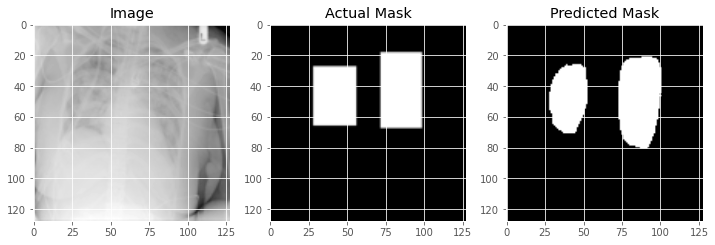

In [ ]:
img_num = np.random.randint(0, val_df.shape[0])
mask_prediction(img_num, val_df)

# Random Prediction of Masks

In [ ]:
def random_predictions(number,df):
    i=0
    plt.figure(figsize=(10,10))
    for i in range(number):
        plt.subplot(3, 3, i+1)
        img_num = np.random.randint(0, val_df.shape[0])
        mask_prediction(img_num, val_df)

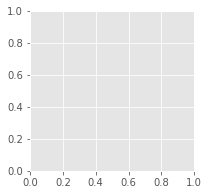

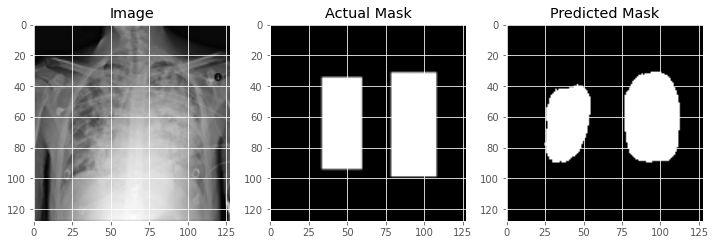

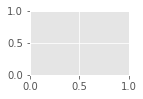

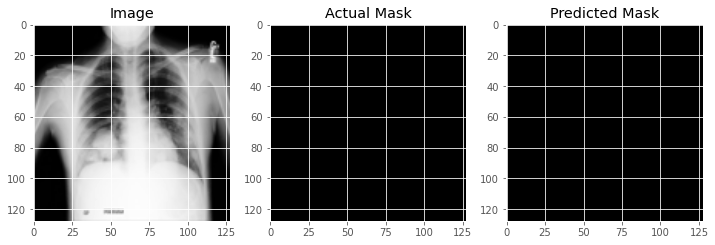

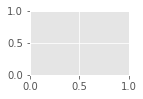

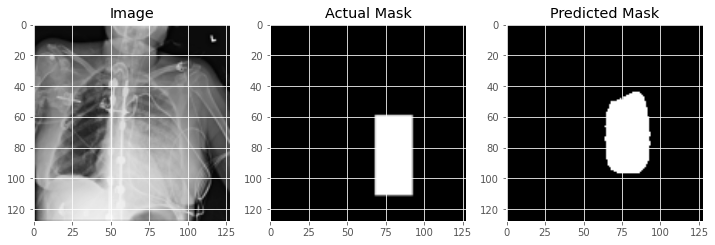

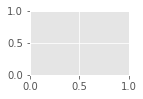

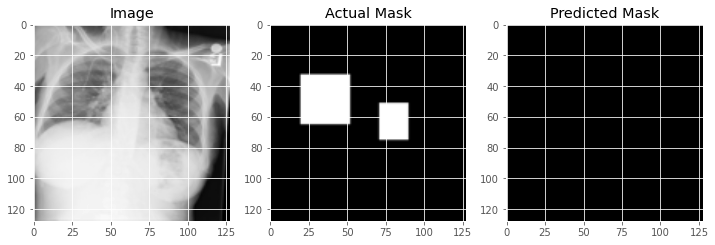

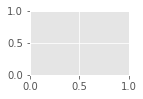

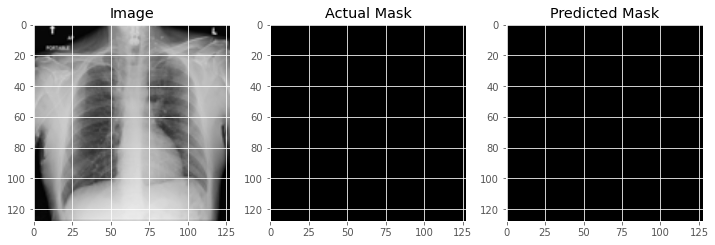

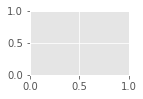

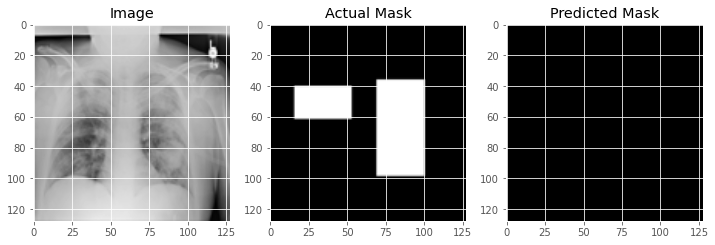

In [ ]:
random_predictions(6,val_df)

# Checking the model performance with different metrices

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models


  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-y79ki59q
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-y79ki59q
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=082b5a92ad09f67e47b24ab761e5fd558b5566f673ebebd297dbd5fd8da8b53a
  Stored in directory: /tmp/pip-ephem-wheel-cache-vwor8apy/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
import segmentation_models as sm
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

Segmentation Models: using `keras` framework.


In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('Mask_UNetBaseModel_metricsF1Score.h5', save_weights_only=True, save_best_only=True,
                                    monitor='val_f1-score'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//64, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//64, 
          callbacks=[callbacks],initial_epoch=8
          epochs=20)

Epoch 1/8
150/150 [==============================] - 3247s 22s/step - loss: 0.6128 - iou_score: 0.2965 - f1-score: 0.4140 - val_loss: 0.6683 - val_iou_score: 0.1581 - val_f1-score: 0.2634 - lr: 1.0000e-04
Epoch 2/8
150/150 [==============================] - 1398s 9s/step - loss: 0.5405 - iou_score: 0.4311 - f1-score: 0.5483 - val_loss: 0.7029 - val_iou_score: 0.1515 - val_f1-score: 0.2550 - lr: 1.0000e-04
Epoch 3/8
150/150 [==============================] - 666s 4s/step - loss: 0.5047 - iou_score: 0.4971 - f1-score: 0.6099 - val_loss: 0.6120 - val_iou_score: 0.3714 - val_f1-score: 0.4917 - lr: 1.0000e-04
Epoch 4/8
150/150 [==============================] - 490s 3s/step - loss: 0.4759 - iou_score: 0.6041 - f1-score: 0.7075 - val_loss: 0.4941 - val_iou_score: 0.5463 - val_f1-score: 0.6487 - lr: 1.0000e-04
Epoch 5/8
150/150 [==============================] - 348s 2s/step - loss: 0.4550 - iou_score: 0.6200 - f1-score: 0.7226 - val_loss: 0.4847 - val_iou_score: 0.5584 - val_f1-score: 0.6605

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//64, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//64, 
          callbacks=[callbacks],initial_epoch=8,
          epochs=20)

Epoch 9/20
150/150 [==============================] - 328s 2s/step - loss: 0.3825 - iou_score: 0.6479 - f1-score: 0.7493 - val_loss: 0.4148 - val_iou_score: 0.5951 - val_f1-score: 0.7011 - lr: 1.0000e-04
Epoch 10/20
150/150 [==============================] - 322s 2s/step - loss: 0.3635 - iou_score: 0.6520 - f1-score: 0.7535 - val_loss: 0.4042 - val_iou_score: 0.5936 - val_f1-score: 0.6984 - lr: 1.0000e-04
Epoch 11/20
150/150 [==============================] - 312s 2s/step - loss: 0.3517 - iou_score: 0.6549 - f1-score: 0.7555 - val_loss: 0.3636 - val_iou_score: 0.6331 - val_f1-score: 0.7337 - lr: 1.0000e-04
Epoch 12/20
150/150 [==============================] - 312s 2s/step - loss: 0.3379 - iou_score: 0.6582 - f1-score: 0.7586 - val_loss: 0.3617 - val_iou_score: 0.6213 - val_f1-score: 0.7251 - lr: 1.0000e-04
Epoch 13/20
150/150 [==============================] - 297s 2s/step - loss: 0.3251 - iou_score: 0.6617 - f1-score: 0.7619 - val_loss: 0.3657 - val_iou_score: 0.6078 - val_f1-score: 

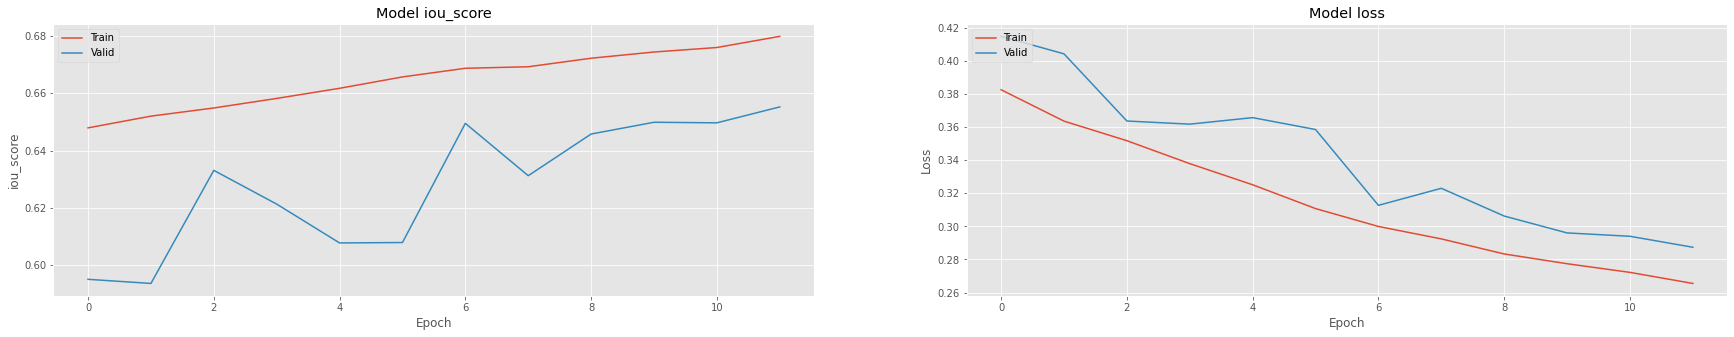

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

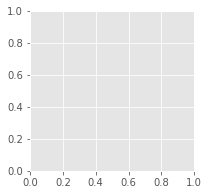

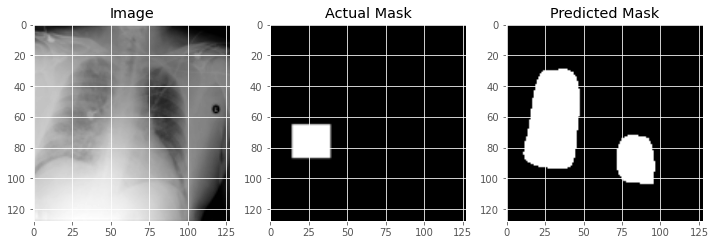

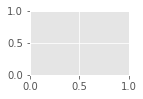

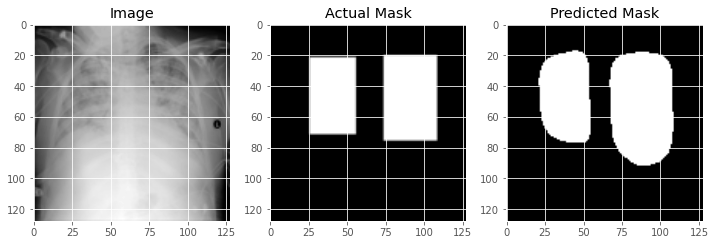

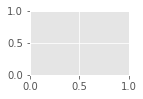

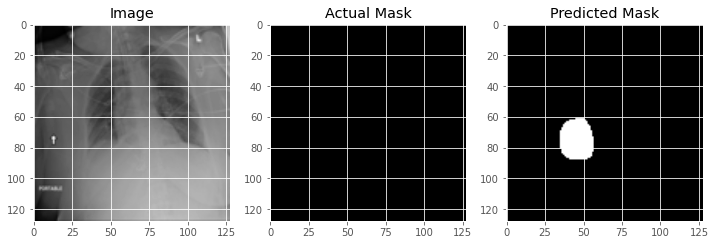

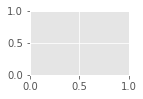

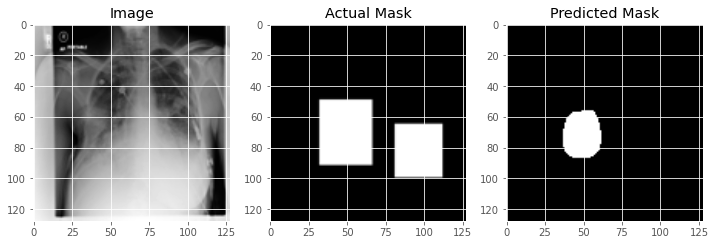

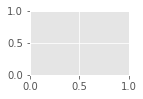

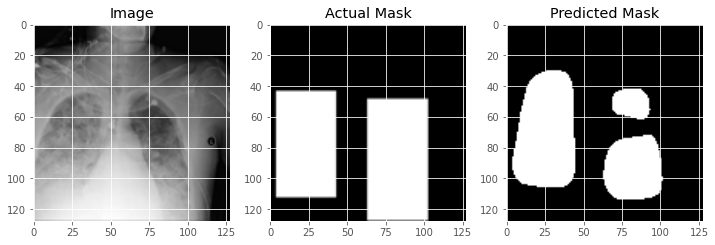

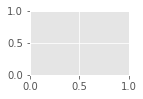

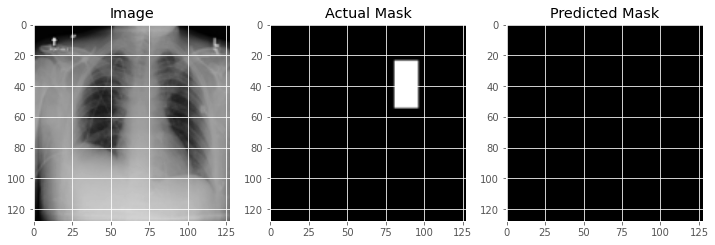

In [ ]:
random_predictions(6,val_df)

## Model - With Complate images of Train data

In [ ]:
idx = np.random.rand(len(train_dp)) < 0.8
val_df = train_dp[~idx]
train_df = train_dp[idx]
val_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

In [ ]:
import segmentation_models as sm
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Mask_UNetBaseModel_CompleTraindata-{loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
train_generator = batch_generator(train_df,batch_size=128)
val_generator = batch_generator(val_df, batch_size=64)

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//128, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//64, 
          callbacks=[checkpoint, reduce_lr, stop],
          epochs=5)

Epoch 1/10
166/166 [==============================] - ETA: 0s - loss: 0.5678 - iou_score: 0.5031 - f1-score: 0.5681 
Epoch 1: val_loss improved from inf to 1.31379, saving model to Mask_UNetBaseModel_CompleTraindata-0.57.h5
166/166 [==============================] - 7942s 48s/step - loss: 0.5678 - iou_score: 0.5031 - f1-score: 0.5681 - val_loss: 1.3138 - val_iou_score: 0.2572 - val_f1-score: 0.3617 - lr: 1.0000e-04
Epoch 2/10
166/166 [==============================] - ETA: 0s - loss: 0.4975 - iou_score: 0.5821 - f1-score: 0.6641 
Epoch 2: val_loss improved from 1.31379 to 0.52021, saving model to Mask_UNetBaseModel_CompleTraindata-0.50.h5
166/166 [==============================] - 5858s 35s/step - loss: 0.4975 - iou_score: 0.5821 - f1-score: 0.6641 - val_loss: 0.5202 - val_iou_score: 0.5562 - val_f1-score: 0.6327 - lr: 1.0000e-04
Epoch 3/10
166/166 [==============================] - ETA: 0s - loss: 0.4615 - iou_score: 0.5981 - f1-score: 0.6829 
Epoch 3: val_loss improved from 0.52021 t

# Model Improvements

###  Using Encoder with Transfer Learning Backbone -ResNet34

In [17]:
img_size = 224
num_classes = 2

In [18]:
from tensorflow.keras.applications import MobileNetV2
#tf.keras.applications.mobilenet_v2.preprocess_input 
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [19]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-o1237itw
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-o1237itw
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 3.1 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=ca9d2a07ac8e96ffa945ac432f769c9ca5e738fe326115c5f9d2521316d91374
  Stored in directory: /tmp/pip-ephem-wheel-cache-jb5ackqx/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [20]:
#Import libraries
import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models import Unet
from segmentation_models.backbones.backbones_factory import Backbones
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

Segmentation Models: using `keras` framework.


In [21]:
# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Mask_Transferlearning-{loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-4, verbose=1, mode="min")

In [23]:
idx = np.random.rand(len(train_dp)) < 0.7
val_df = train_dp[~idx]
train_df = train_dp[idx]
val_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

In [24]:
# define optomizer
import segmentation_models as sm
# define network parameters
# case for binary and multiclass segmentation
activation = 'sigmoid' if num_classes == 1 else 'softmax'

In [25]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [26]:
base_model = Unet(backbone_name='resnet34', classes=num_classes,  encoder_weights='imagenet', activation=activation)

85532672/85521592 [==============================] - 1s 0us/step


In [27]:
# Since X ray images are Gray and Transfer model requires channels of 3 we need to change the input image to 3 channels
from keras.layers import Reshape

inp = Input(shape=(img_size, img_size, 1))

l1 = Conv2D(3, (1, 1))(inp)

out = base_model(l1)

model = Model(inp, out, name=base_model.name)

In [28]:
def batch_generator(df, batch_size=32):

    while True:

        #Create random indexes
        idx = np.random.randint(0, df.shape[0], batch_size)

        #Initialize numpy arrays for X and y
        #Input image is size img_size,img_size,1
        
        X = np.zeros((batch_size, img_size, img_size, 1), dtype=np.float32)
        #Mask's size is img_size, img_size, 1
        y = np.zeros((batch_size, img_size, img_size,num_classes))
        #y = np.zeros((batch_size, img_size, img_size,1))

        #Populate X and y with actual data
        for i in range(len(idx)):

            #Read image
            img = tf.keras.preprocessing.image.load_img('image_jpeg/' + df.loc[idx[i],'patientId'] + '.jpg', color_mode='grayscale',
                                                        target_size=(img_size, img_size))
            #img = img.convert('RGB')
            img= np.reshape(img.convert('L'), (img_size,img_size,1))
            
            img = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')/255.0
                  # Normalization when using Resnet34 or any Pretrained model
            img = preprocess_input(img)

            X[i] = img

            #Read mask
            mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[idx[i],'patientId'] + '.jpg',
                                                            color_mode = 'grayscale',
                                                            target_size=(img_size, img_size))
            mask_img = tf.keras.preprocessing.image.img_to_array(mask_img).astype('uint8')/255.0
            mask_img = tf.keras.utils.to_categorical(mask_img, num_classes=num_classes)

            y[i] = mask_img

        yield X, y

In [29]:
LR = 0.00001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [30]:
a = batch_generator(train_df, batch_size=2)
x, y = next(a)

In [31]:
x.shape

(2, 224, 224, 1)

In [32]:
train_generator = batch_generator(train_df,batch_size=128)
val_generator = batch_generator(val_df, batch_size=64)

In [33]:
history = model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//128, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//64, 
          callbacks=[checkpoint,stop,reduce_lr],
          epochs=2)

Epoch 1/2
145/145 [==============================] - ETA: 0s - loss: 0.6444 - iou_score: 0.3590 - f1-score: 0.4489 
Epoch 1: val_loss improved from inf to 0.63475, saving model to Mask_Transferlearning-0.64.h5
145/145 [==============================] - 5650s 39s/step - loss: 0.6444 - iou_score: 0.3590 - f1-score: 0.4489 - val_loss: 0.6348 - val_iou_score: 0.3473 - val_f1-score: 0.4410 - lr: 1.0000e-05
Epoch 2/2
145/145 [==============================] - ETA: 0s - loss: 0.5606 - iou_score: 0.5300 - f1-score: 0.6134 
Epoch 2: val_loss improved from 0.63475 to 0.56251, saving model to Mask_Transferlearning-0.56.h5
145/145 [==============================] - 2516s 17s/step - loss: 0.5606 - iou_score: 0.5300 - f1-score: 0.6134 - val_loss: 0.5625 - val_iou_score: 0.4905 - val_f1-score: 0.5045 - lr: 1.0000e-05


In [59]:
history = model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//128, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//64, 
          callbacks=[checkpoint,stop,reduce_lr],initial_epoch=5,
          epochs=10)

Epoch 6/10
145/145 [==============================] - ETA: 0s - loss: 0.4290 - iou_score: 0.7115 - f1-score: 0.8018
Epoch 6: val_loss improved from 0.55536 to 0.48371, saving model to Mask_Transferlearning-0.43.h5
145/145 [==============================] - 660s 5s/step - loss: 0.4290 - iou_score: 0.7115 - f1-score: 0.8018 - val_loss: 0.4837 - val_iou_score: 0.5704 - val_f1-score: 0.6470 - lr: 1.0000e-05
Epoch 7/10
145/145 [==============================] - ETA: 0s - loss: 0.4006 - iou_score: 0.7433 - f1-score: 0.8304
Epoch 7: val_loss improved from 0.48371 to 0.45652, saving model to Mask_Transferlearning-0.40.h5
145/145 [==============================] - 634s 4s/step - loss: 0.4006 - iou_score: 0.7433 - f1-score: 0.8304 - val_loss: 0.4565 - val_iou_score: 0.6090 - val_f1-score: 0.6914 - lr: 1.0000e-05
Epoch 8/10
145/145 [==============================] - ETA: 0s - loss: 0.3793 - iou_score: 0.7659 - f1-score: 0.8489
Epoch 8: val_loss improved from 0.45652 to 0.44908, saving model to Ma

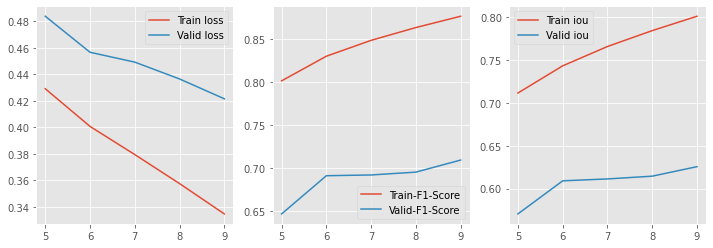

In [60]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

In [61]:
history = model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//128, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//64, 
          callbacks=[checkpoint,stop,reduce_lr],initial_epoch=10,
          epochs=20)

Epoch 11/20
145/145 [==============================] - ETA: 0s - loss: 0.3122 - iou_score: 0.8126 - f1-score: 0.8853
Epoch 11: val_loss improved from 0.42142 to 0.41674, saving model to Mask_Transferlearning-0.31.h5
145/145 [==============================] - 640s 4s/step - loss: 0.3122 - iou_score: 0.8126 - f1-score: 0.8853 - val_loss: 0.4167 - val_iou_score: 0.6202 - val_f1-score: 0.7027 - lr: 1.0000e-05
Epoch 12/20
145/145 [==============================] - ETA: 0s - loss: 0.2930 - iou_score: 0.8276 - f1-score: 0.8967
Epoch 12: val_loss improved from 0.41674 to 0.41032, saving model to Mask_Transferlearning-0.29.h5
145/145 [==============================] - 662s 5s/step - loss: 0.2930 - iou_score: 0.8276 - f1-score: 0.8967 - val_loss: 0.4103 - val_iou_score: 0.6192 - val_f1-score: 0.7008 - lr: 1.0000e-05
Epoch 13/20
145/145 [==============================] - ETA: 0s - loss: 0.2779 - iou_score: 0.8343 - f1-score: 0.9012
Epoch 13: val_loss improved from 0.41032 to 0.40953, saving model

In [63]:
def mask_prediction_transfermodel(img_num, df):

    #test_img = np.zeros((1, img_size, img_size, 3), dtype=np.float32)
    #Read image and corresponding mask
    img = tf.keras.preprocessing.image.load_img('image_jpeg/' + df.loc[img_num, 'patientId'] + '.jpg', 
                                                color_mode='grayscale',target_size=(img_size, img_size))
    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg',
                                                     color_mode='grayscale')

    #Model prediction
    test_img= np.reshape(img.convert('L'), (img_size,img_size,1))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
    
    test_img = preprocess_input(test_img)
    
    #test_img = np.expand_dims(test_img, axis=2) #1,128,128,1
    test_img = np.expand_dims(test_img, axis=0)
    #pr_mask = model.predict(test_img).round()
    
    #test_img = np.stack((test_img,)*3, axis=-1)

    pred = model.predict(test_img) #1,128,128,num_classes
    
    predicted_classes = np.argmax(pred[0], axis=-1)

    #pred_mask=model.predict(x=np.array([test_img]))[0] > 0.5
    
    #Create a pyplot with two images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))

    #Show both images
    ax1.set_title('Image')
    ax1.imshow(img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Actual Mask')
    ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax3.set_title('Predicted Mask')
    ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    #ax3.imshow(pr_mask[..., 0].squeeze(), cmap = 'gray', interpolation = 'bilinear')


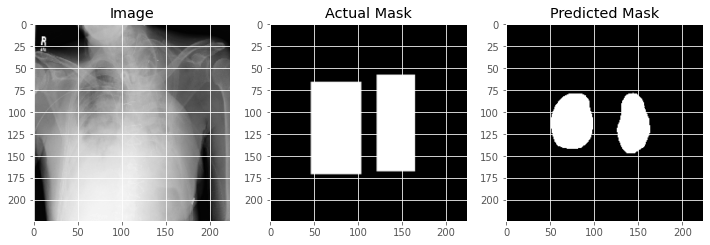

In [69]:
img_num = np.random.randint(0, val_df.shape[0])
mask_prediction_transfermodel(img_num, val_df)

# Model - Segementation -UNet - Observations
* Planed with Own Unet Network and trained the model by down sampling the train data with 6000 images
* Initial Metric considered was val accuracy and could reach 94% with less than 10iterations
* Metric changed to F1 score and IOU and by 20iterations could reach validation score of F1 to 0.76 and IOU of 0.65.
* No Overfitting observed
* Based Unet model is trained on complete train images and with in 5 iterations the F1 score is 0.69 and IOU of 0.60
* Unet with Encoder using transfer model of Resnet 34 on complete train images F1 score is  0.71 and IOU of 0.62
* It was observed that when we downsample the train data there is less tendancy of overfit. But once included the complete train data the model has tendancy of overfitting and may require augmentation
* It was observed that standalone model was helping for better predictions than transfer learning model for Encoder